In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
import cartopy.crs as ccrs
import seawater as sw
import gsw
import xgcm
from xgcm.autogenerate import generate_grid_ds
from cmocean import cm

from matplotlib import pyplot as plt
%matplotlib inline

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py:137: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  RuntimeWarning,


In [2]:
from dask_jobqueue import PBSCluster
cluster = PBSCluster()
#print(cluster.job_script())
#print(cluster.job_header)
w = cluster.scale(20)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

<Client: 'tcp://10.148.1.31:51458' processes=20 threads=280, memory=1.20 TB>

________________
### Readme: 
In this notebook, some basic information (e.g., bathymetry of the model domain, record-mean/max/min mixed layer depth, snapshots of u,v,w,b) are given in section 2. 

Section 3 displays some estimates based on the model output such as Rossby number, lateral buoyancy gradient, PV, Frontogenesis function. 

Raw outputs and 1-day low-pass filtered data are used in Section 3.

_________
# 1. Read dataset



In [8]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/data_rechunk/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U = xr.open_zarr(out_dir_zarr+'U_total_rechunk.zarr')
ds_V = xr.open_zarr(out_dir_zarr+'V_total_rechunk.zarr')
ds_W = xr.open_zarr(out_dir_zarr+'W_total_rechunk.zarr')
ds_B = xr.open_zarr(out_dir_zarr+'Buoy_total_rechunk.zarr')
ds_MLD = xr.open_zarr('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/mld_filter.zarr')

ds = xr.merge([ds_U,ds_V,ds_W,ds_B,ds_MLD,grid])
ds = generate_grid_ds(ds, {'Z':'depth'})

# define (real) time
def iters_to_date(iters, delta_t=3600.):
    t0 = datetime.datetime(2011,9,13,0)    
    ltime = delta_t * (np.array(iters))
    dtime = [t0+dateutil.relativedelta.relativedelta(seconds=t) for t in ltime]    
    return dtime

time_day = iters_to_date(np.arange(9415))

ds = ds.assign_coords(time=time_day) 

print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ...
   

In [7]:
grid = xr.open_dataset(out_dir_zarr+'Grid.nc', decode_coords=True)

ds_KPP = xr.open_zarr(out_dir_zarr+'KPPhbl_total_rechunk.zarr')
ds_Eta = xr.open_zarr(out_dir_zarr+'Eta_total_rechunk.zarr')
ds_taux = xr.open_zarr(out_dir_zarr+'oceTAUX_total_rechunk.zarr')
ds_tauy = xr.open_zarr(out_dir_zarr+'oceTAUY_total_rechunk.zarr')
ds_fwflx = xr.open_zarr(out_dir_zarr+'oceFWflx_total_rechunk.zarr')
ds_qnet = xr.open_zarr(out_dir_zarr+'oceQnet_total_rechunk.zarr')
ds_qsw = xr.open_zarr(out_dir_zarr+'oceQsw_total_rechunk.zarr')
ds_sflux = xr.open_zarr(out_dir_zarr+'oceSflux_total_rechunk.zarr')

ds_surface = xr.merge([ds_KPP,ds_Eta,ds_taux,ds_tauy,ds_fwflx,ds_qnet,ds_qsw,ds_sflux,grid])

In [9]:
gridx = xgcm.Grid(ds, coords={'X':{'center':'lon', 'left':'lon_g'},
                              'Y':{'center':'lat', 'left':'lat_g'},
                              'Z':{'center':'depth', 'left':'depth_left'}}, periodic=['X', 'Y'])
print(gridx)

<xgcm.Grid>
X Axis (periodic):
  * center   lon --> left
  * left     lon_g --> center
Y Axis (periodic):
  * center   lat --> left
  * left     lat_g --> center
Z Axis (not periodic):
  * center   depth --> left
  * left     depth_left --> center


In [10]:
# Calculate vertical distances located on the cellboundary
ds.coords['dzc'] = gridx.diff(ds.depth, 'Z', boundary='extrapolate')
# Calculate vertical distances located on the cellcenter
ds.coords['dzt'] = gridx.diff(ds.depth_left, 'Z', boundary='extrapolate')
ds

<xarray.Dataset>
Dimensions:     (depth: 52, depth_left: 52, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 9415)
Coordinates:
  * lat         (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon_g       (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
  * depth       (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * time        (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * lat_g       (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon         (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    XC          (lat, lon) float32 ...
    YC          (lat, lon) float32 ...
    XG          (lat_g, lon_g) float32 ...
    YG          (lat_g, lon_g) float32 ...
    CS          (lat, lon) float32 ...
    SN          (lat, lon) float32 ...
    Depth       (lat, lon) float32 ...
    dxC         (lat, lon_g) float32 ...
    dyC         (lat_g, lon) float32 ...
    dxG         (lat_g, lon) float32 ...
   

In [11]:
lat = ds['YG']
omega = 7.3/100000
f = 2*omega*np.sin(np.deg2rad(lat))
f_i = gridx.interp(f,'X')
f_j = gridx.interp(f,'Y')
f_ij = gridx.interp(f_i,'Y')
f

<xarray.DataArray 'YG' (lat_g: 201, lon_g: 177)>
array([[0.00010747, 0.00010747, 0.00010747, ..., 0.00010747, 0.00010747,
        0.00010747],
       [0.00010749, 0.00010749, 0.00010749, ..., 0.00010749, 0.00010749,
        0.00010749],
       [0.00010751, 0.00010751, 0.00010751, ..., 0.00010751, 0.00010751,
        0.00010751],
       ...,
       [0.00011177, 0.00011177, 0.00011177, ..., 0.00011177, 0.00011177,
        0.00011177],
       [0.00011179, 0.00011179, 0.00011179, ..., 0.00011179, 0.00011179,
        0.00011179],
       [0.00011181, 0.00011181, 0.00011181, ..., 0.00011181, 0.00011181,
        0.00011181]], dtype=float32)
Coordinates:
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
    XG       (lat_g, lon_g) float32 ...
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 ...

In [12]:
out_dir_zarr = '/home/c11-data/Test_aponte/xiaolong/Parameter/LLC4320/filtered_uv_data/'

grid = xr.open_dataset('/home1/datawork/xyu/OSMOSIS_llc4320/data_rechunk/Grid.nc', decode_coords=True)
ds_U_lowpass = xr.open_zarr(out_dir_zarr+'U_lowpass_30h_filter_rechunk.zarr')
ds_V_lowpass = xr.open_zarr(out_dir_zarr+'V_lowpass_30h_filter_rechunk.zarr')
ds_W_lowpass = xr.open_zarr(out_dir_zarr+'W_lowpass_30h_filter_rechunk.zarr')
ds_P_lowpass = xr.open_zarr(out_dir_zarr+'P_lowpass_30h_filter_rechunk.zarr')

# buoyancy
ds_B_lowpass = -9.81*(ds_P_lowpass.B_low_filter-25)/1025
ds_B_lowpass = np.real(ds_B_lowpass).rename('B_low_filter')
ds_B_lowpass = ds_B_lowpass.to_dataset()

ds_filter = xr.merge([ds_U_lowpass,ds_V_lowpass,ds_W_lowpass,ds_B_lowpass,grid])
print(ds_filter)
print('\n data size: %.1f GB' %(ds_filter.nbytes / 1e9))

<xarray.Dataset>
Dimensions:       (depth: 40, lat: 201, lat_g: 201, lon: 177, lon_g: 177, time: 8761)
Coordinates:
  * depth         (depth) float64 0.5 1.57 2.79 4.185 ... 441.3 473.3 506.5
    dxC           (lat, lon_g) float32 1567.638 1567.638 ... 1489.2013 1489.2013
    dyG           (lat, lon_g) float32 1468.5818 1468.5818 ... 1403.369 1403.369
  * lat           (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon_g         (lon_g) float64 -18.04 -18.02 -18.0 ... -14.42 -14.4 -14.38
    rAw           (lat, lon_g) float32 2302204.5 2302204.5 ... 2089899.0
  * time          (time) datetime64[ns] 2011-09-13 ... 2012-09-12
    dxG           (lat_g, lon) float32 1567.8346 1567.8346 ... 1489.3967
    dyC           (lat_g, lon) float32 1468.746 1468.746 ... 1403.5306 1403.5306
  * lat_g         (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.96 49.97 49.98
  * lon           (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rAs           (lat_g, lon) float32 23

# 2. Basics

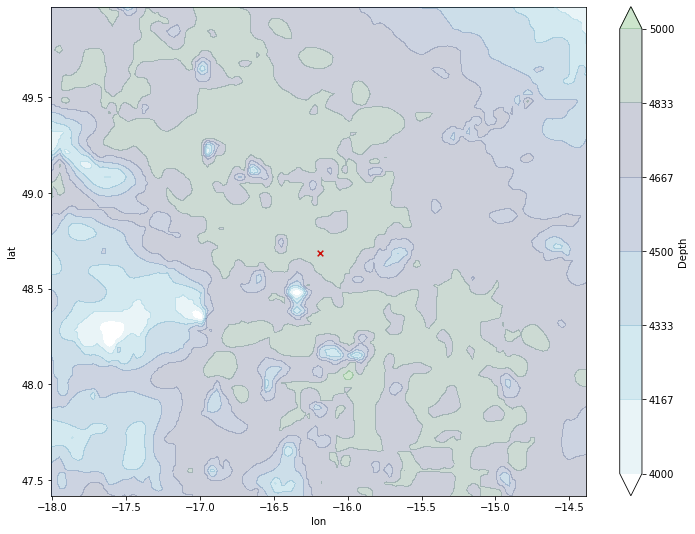

In [13]:
bathymetry = ds.Depth

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)
bathymetry.isel(lat=slice(1,-1),lon=slice(1,-1)).plot.contourf(x='lon', y='lat', vmin=4000, vmax=5000, cmap='ocean_r',alpha=0.2, zorder=4)
ax.scatter(-16.1875,48.6875,s=32,marker='x',color='r')
#plt.contourf(x_topo,y_topo,topo[i0:i1,j0:j1],cmap='ocean_r', alpha=0.2, zorder=1)

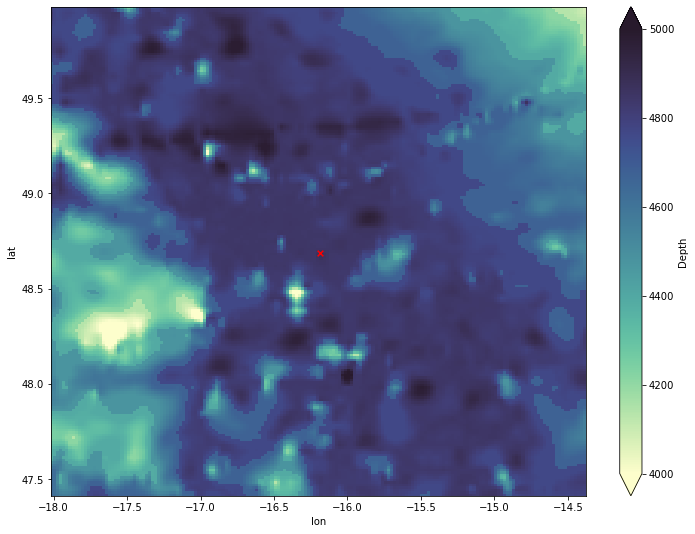

In [18]:
bathymetry = ds.Depth

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)

bathymetry.isel(lat=slice(1,-1),lon=slice(1,-1)).plot(x='lon', y='lat', vmin=4000, vmax=5000, cmap=cm.deep)
ax.scatter(-16.1875,48.6875,s=32,marker='x',color='r')

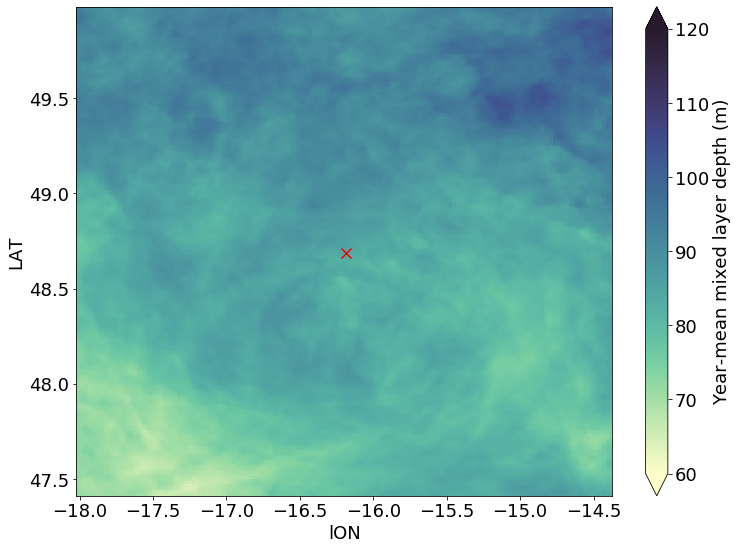

In [20]:
font_size = 18

fig = plt.figure(figsize=(12,9))
ax = plt.subplot(111)

cax=ds.mld_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['time']).plot(x='lon', y='lat', vmin=60, vmax=120, cmap=cm.deep, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')

cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Year-mean mixed layer depth (m)', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

plt.savefig('/home1/datawork/xyu/OSMOSIS_llc4320/Figures/MLD_map.png')


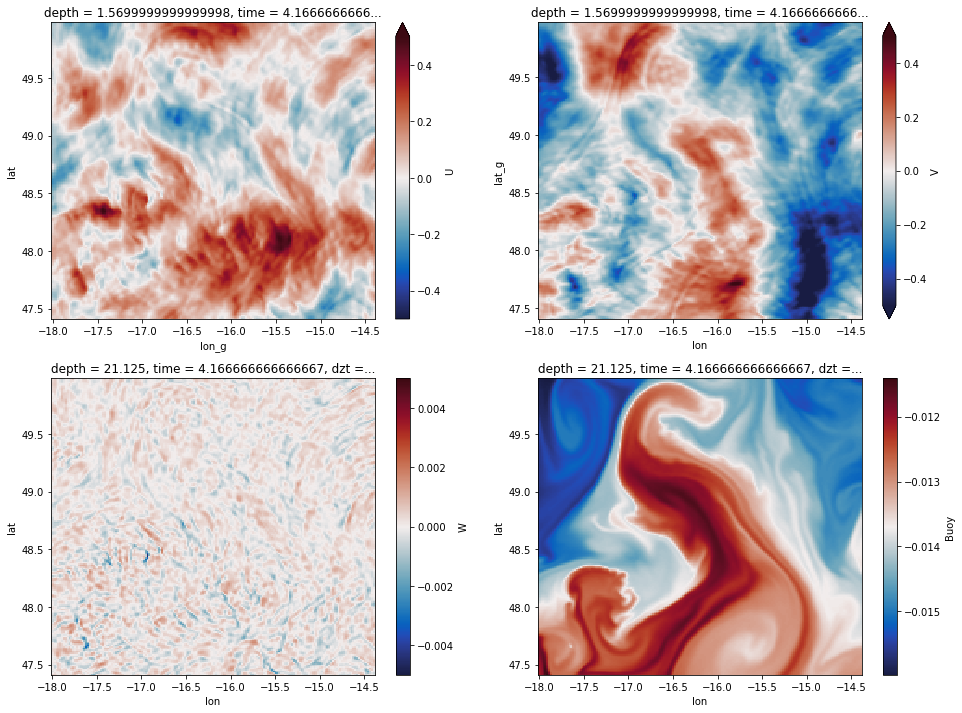

In [12]:
fig = plt.figure(figsize=(16,12))

plt.subplot(221)
ds.U.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=1).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(222)
ds.V.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=1).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(223)
ds.W.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.005, vmax=0.005, cmap=cm.balance)
plt.subplot(224)
ds.Buoy.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

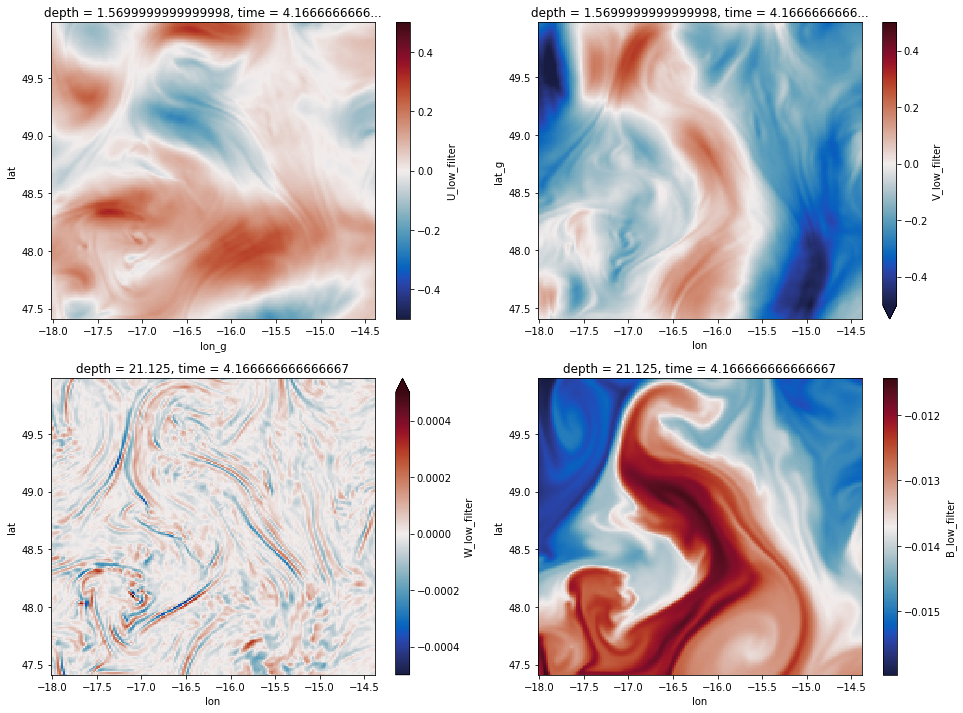

In [15]:
fig = plt.figure(figsize=(16,12))

plt.subplot(221)
ds_filter.U_low_filter.isel(lat=slice(1,-1),lon_g=slice(1,-1), time=100, depth=1).plot(x='lon_g', y='lat', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(222)
ds_filter.V_low_filter.isel(lat_g=slice(1,-1),lon=slice(1,-1), time=100, depth=1).plot(x='lon', y='lat_g', vmin=-0.5, vmax=0.5, cmap=cm.balance)
plt.subplot(223)
ds_filter.W_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', vmin=-0.0005, vmax=0.0005, cmap=cm.balance)
plt.subplot(224)
ds_filter.B_low_filter.isel(lat=slice(1,-1),lon=slice(1,-1), time=100, depth=10).plot(x='lon', y='lat', cmap=cm.balance)

# 3. Parameter

## 3.1 Rossby number

In [14]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_f = (zeta/f)

zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_filter_f = (zeta_filter/f)

print(zeta_f)

<xarray.DataArray (lat_g: 201, lon_g: 177, time: 9415, depth: 52)>
dask.array<truediv, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(1, 176, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat_g    (lat_g) float64 47.4 47.41 47.42 47.44 ... 49.94 49.96 49.97 49.98
  * lon_g    (lon_g) float64 -18.04 -18.02 -18.0 -17.98 ... -14.42 -14.4 -14.38
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XG       (lat_g, lon_g) float32 -18.041666 -18.020834 ... -14.395833 -14.375
    YG       (lat_g, lon_g) float32 47.39811 47.39811 ... 49.981472 49.981472
    rAz      (lat_g, lon_g) float32 2302750.8 2302750.8 ... 2090414.0 2090414.0


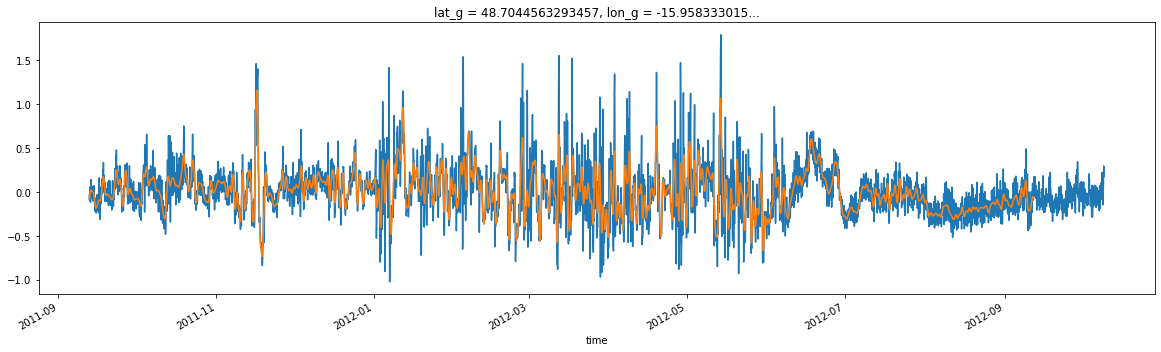

In [15]:
fig = plt.figure(figsize=(20,5))

zeta_f.isel(lat_g=100, lon_g=100,depth=1).plot()
zeta_filter_f.isel(lat_g=100, lon_g=100,depth=1).plot()

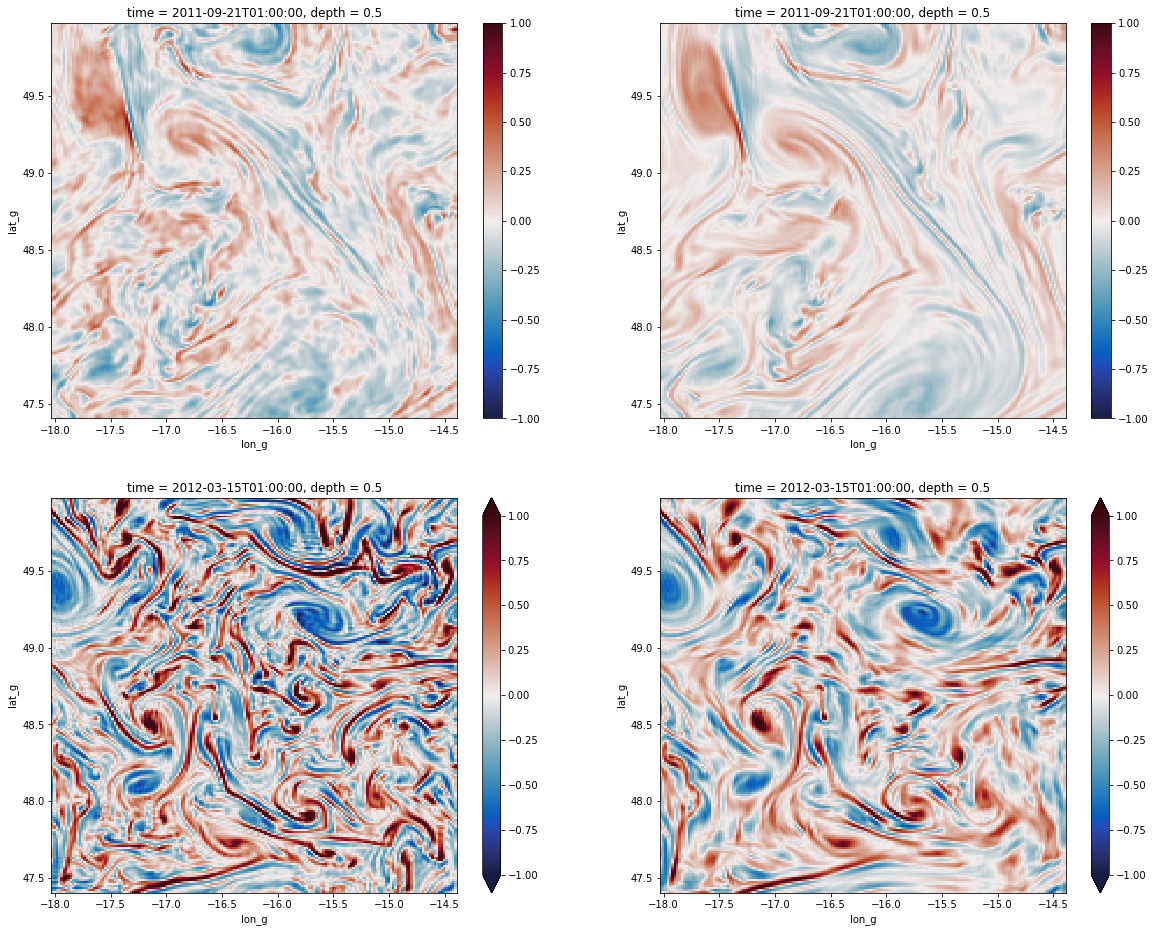

In [22]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(222)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

plt.subplot(223)
zeta_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)
plt.subplot(224)
zeta_filter_f.isel(lat_g=slice(1,-1),lon_g=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon_g', y='lat_g', vmin=-1, vmax=1, cmap=cm.balance)

## 3.2 KE

In [23]:
KE = (gridx.interp(ds['U']**2,'X') + gridx.interp(ds['V']**2,'Y'))/2 # KE
KE_filter = (gridx.interp(ds_filter['U_low_filter']**2,'X') + gridx.interp(ds_filter['V_low_filter']**2,'Y'))/2 # KE_filter
KE

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

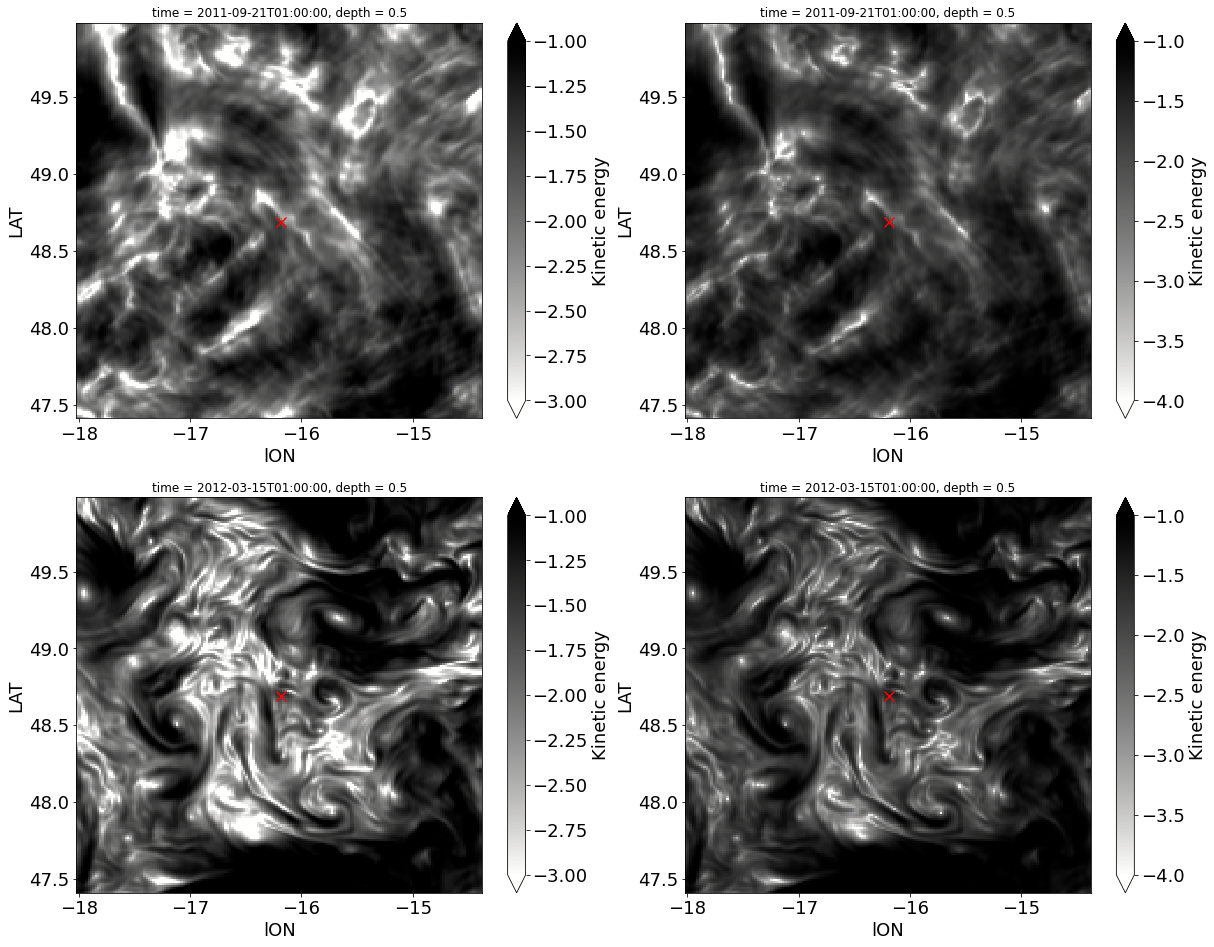

In [24]:
font_size = 18

fig = plt.figure(figsize=(20,16))

ax = plt.subplot(221)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-3, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(222)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-4, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(223)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-3, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

ax = plt.subplot(224)
cax=np.log10(KE).isel(lat=slice(1,-1),lon=slice(1,-1), depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-4, vmax=-1, cmap=cm.gray_r, add_colorbar = False)
ax.scatter(-16.1875,48.6875,s=100,marker='x',color='r')
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
cbar.set_label('Kinetic energy', fontsize=font_size)
ax.set_ylabel('LAT',fontsize=font_size)
ax.set_xlabel('lON',fontsize=font_size)
ax.tick_params(labelsize=font_size)

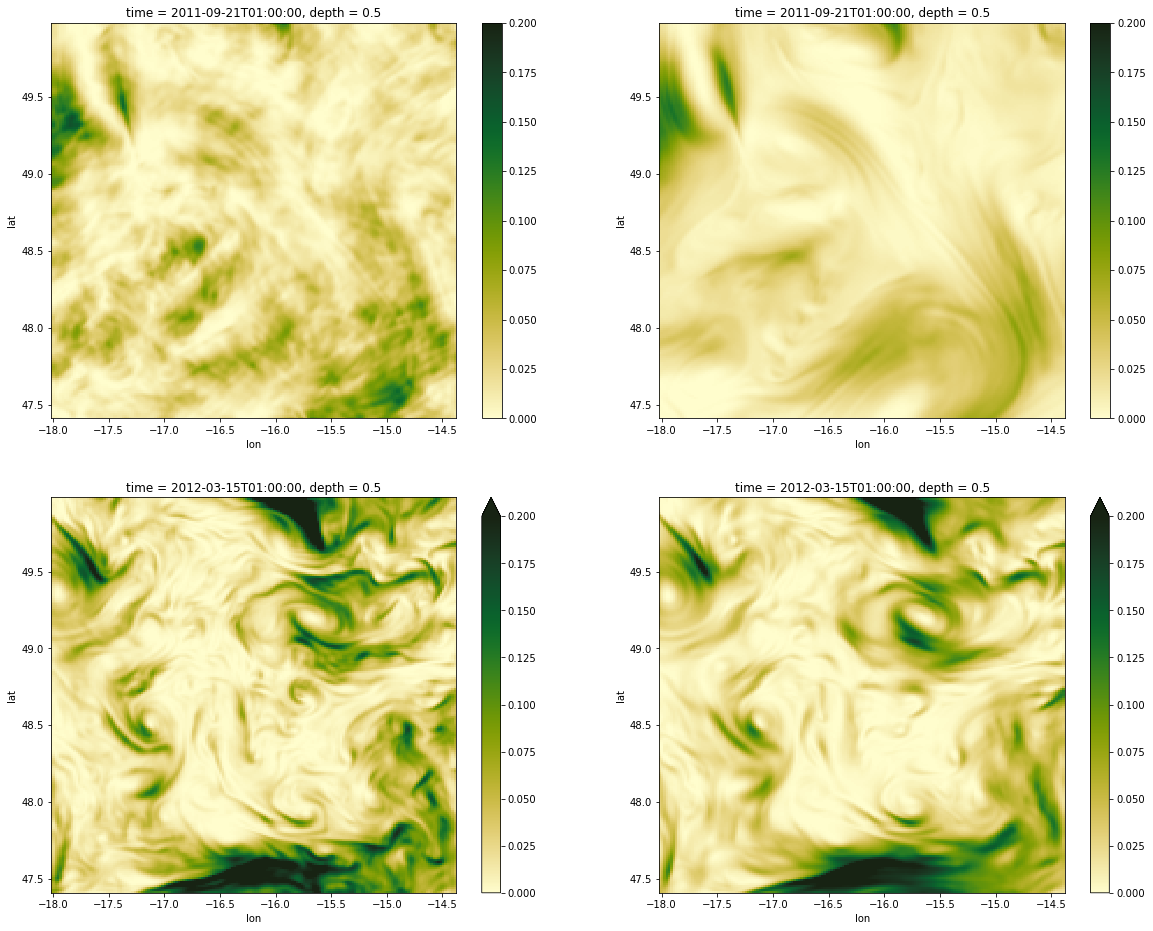

In [25]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
KE.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(222)
KE_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(223)
KE.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)
plt.subplot(224)
KE_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=0.2, cmap=cm.speed)

## 3.3 Horizontal strain

In [25]:
strain = (gridx.diff(ds['U'] * ds.dyG, 'X') - gridx.diff(ds['V']* ds.dxG, 'Y')) / ds.rA
strain_f = (strain/f_ij)

strain_filter = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA
strain_f_filter = (strain_filter/f_ij)

strain_f

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
    XC       (lat, lon) float32 ...
    YC       (lat, lon) float32 ...
    CS       (lat, lon) float32 ...
    SN       (lat, lon) float32 ...
    Depth    (lat, lon) float32 ...
    rA       (lat, lon) float32 ...

In [33]:
strain_rate1_filter = (gridx.diff(ds_filter['U_low_filter'] * ds.dyG, 'X') - gridx.diff(ds_filter['V_low_filter']* ds.dxG, 'Y')) / ds.rA
strain_rate2_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') + gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
strain_rate2_filter=strain_rate2_filter.rename({'lat_g': 'lat'})
strain_rate2_filter=strain_rate2_filter.rename({'lon_g': 'lon'})

strain_rate_filter =np.sqrt(strain_rate2_filter**2 + strain_rate2_filter**2)
strain_rate_filter

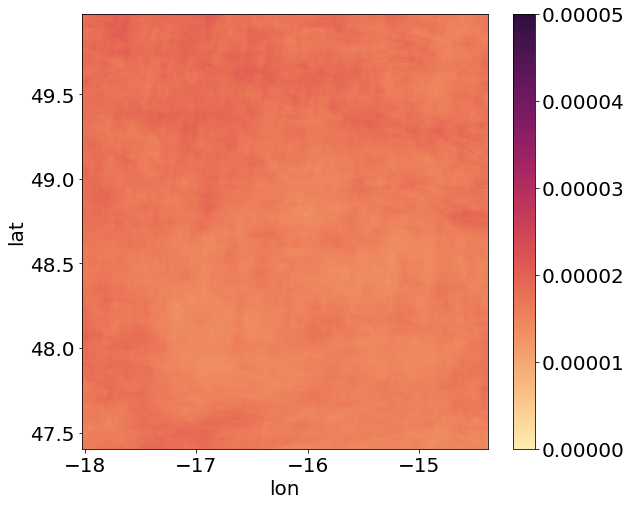

In [46]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
(strain_rate_filter).isel(lat=slice(1,-1),lon=slice(1,-1),depth=slice(0,40)).mean(['depth','time']).plot(x='lon', y='lat', vmin=0,vmax=5e-5, cmap=cm.matter)
#strain_rate_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0,time=1).plot(x='lon', y='lat', cmap=cm.balance)

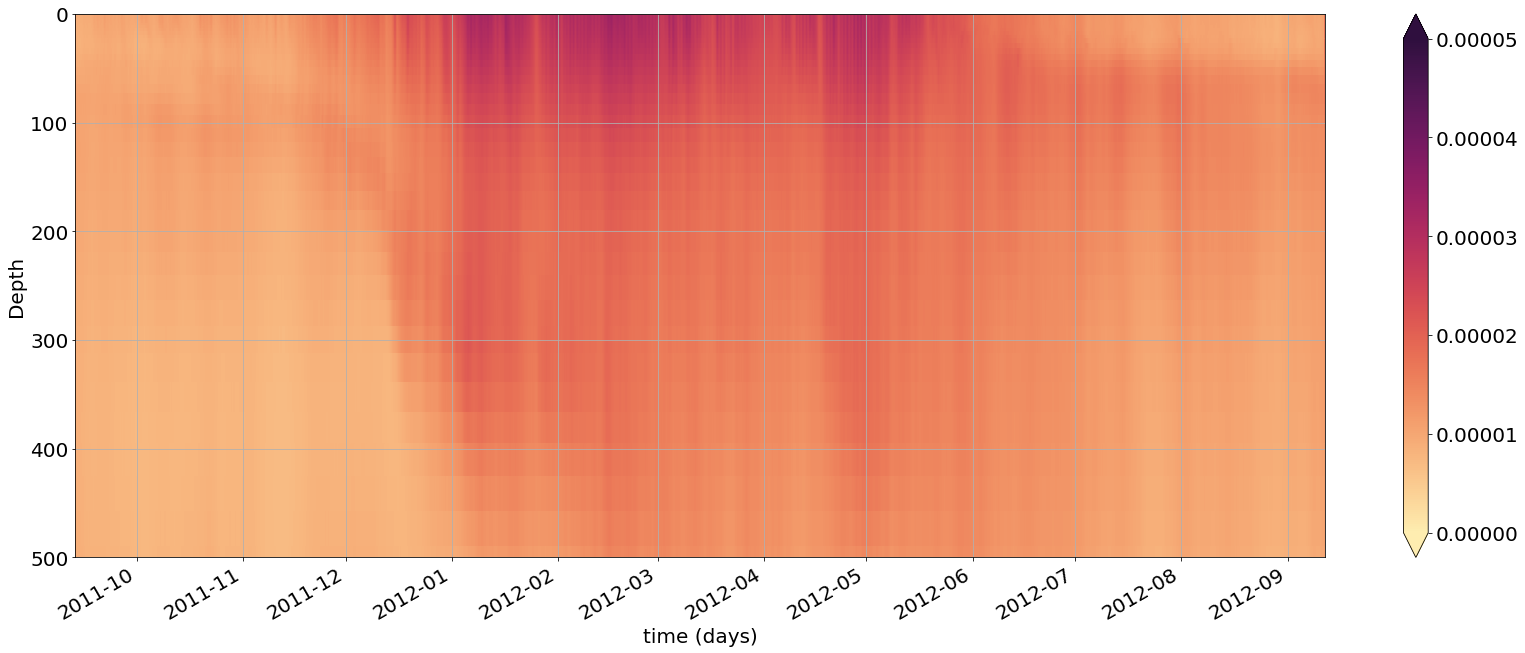

In [47]:
plt.rc('font', size=20) 
font_size=20
fig, ax = plt.subplots(figsize=(28,10))

ax = plt.subplot(111)
cax = strain_rate_filter.isel(lat=slice(1,-1),lon=slice(1,-1)).mean(['lon','lat']).plot(x='time', y='depth',cmap=cm.matter, vmin=0,vmax=5e-5,yincrease=False, add_colorbar = False)
cbar = plt.colorbar(cax, ax=ax, extend='both', orientation='vertical')
cbar.ax.tick_params(labelsize=font_size)
ax.grid()
ax.set_ylim([500., 0.])
ax.set_ylabel('Depth',fontsize=font_size)
ax.set_xlabel('time (days)',fontsize=font_size)
ax.tick_params(labelsize=font_size)

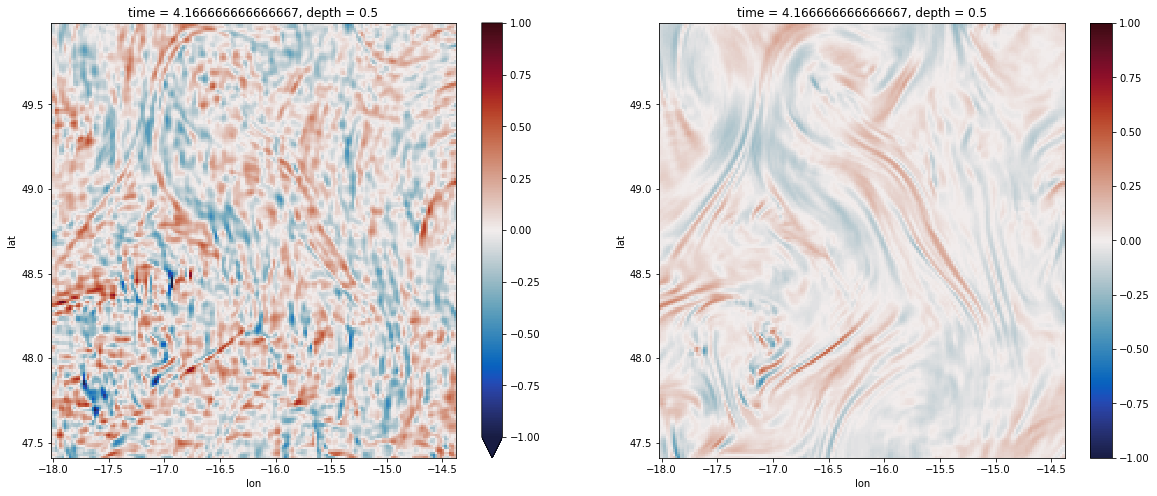

In [27]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
strain_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)
plt.subplot(122)
strain_f_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)

## 3.4 Horizontal divergence

In [17]:
vel_div_components = gridx.diff_2d_vector({'X': ds.dyG * ds['U'], 'Y': ds.dxG * ds['V']}, boundary='extend')
vel_div = (vel_div_components['X'] + vel_div_components['Y'])/ds.rA
vel_div_f = (vel_div/f_ij)

store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'
chunks = {'lat': 201, 'lon': 177, 'time': 9415, 'depth':1}
vel_div_f = vel_div_f.chunk(chunks)
vel_div_f = np.real(vel_div_f).rename('vel_div_f')
vel_div_f = vel_div_f.to_dataset()
print(vel_div_f)
file_out = store_dir_zarr+'/vel_div_f_rechunk.zarr'
%time vel_div_f.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:    (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat        (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon        (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth      (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
    XC         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    CS         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth      (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    rA         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
Data variables:
    vel_div_f  (lat, lon, time, depth) float32 dask.array<chunksize=(201, 177, 

In [16]:
vel_div_components_filter = gridx.diff_2d_vector({'X': ds.dyG * ds_filter['U_low_filter'], 'Y': ds.dxG * ds_filter['V_low_filter']}, boundary='extend')
vel_div_filter = (vel_div_components_filter['X'] + vel_div_components_filter['Y'])/ds.rA
vel_div_f_filter = (vel_div_filter/f_ij)

store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'
chunks = {'lat': 201, 'lon': 177, 'time': 9415, 'depth':1}
vel_div_f_filter = vel_div_f_filter.chunk(chunks)
vel_div_f_filter = np.real(vel_div_f_filter).rename('vel_div_f_filter')
vel_div_f_filter = vel_div_f_filter.to_dataset()
print(vel_div_f_filter)
file_out = store_dir_zarr+'/vel_div_f_filter_rechunk.zarr'
%time vel_div_f_filter.to_zarr(file_out, mode='w')  

<xarray.Dataset>
Dimensions:           (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
  * lat               (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon               (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
  * time              (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
  * depth             (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
    XC                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    CS                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth             (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    rA                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
Data variables:
    vel_div_f_filter  (lat,

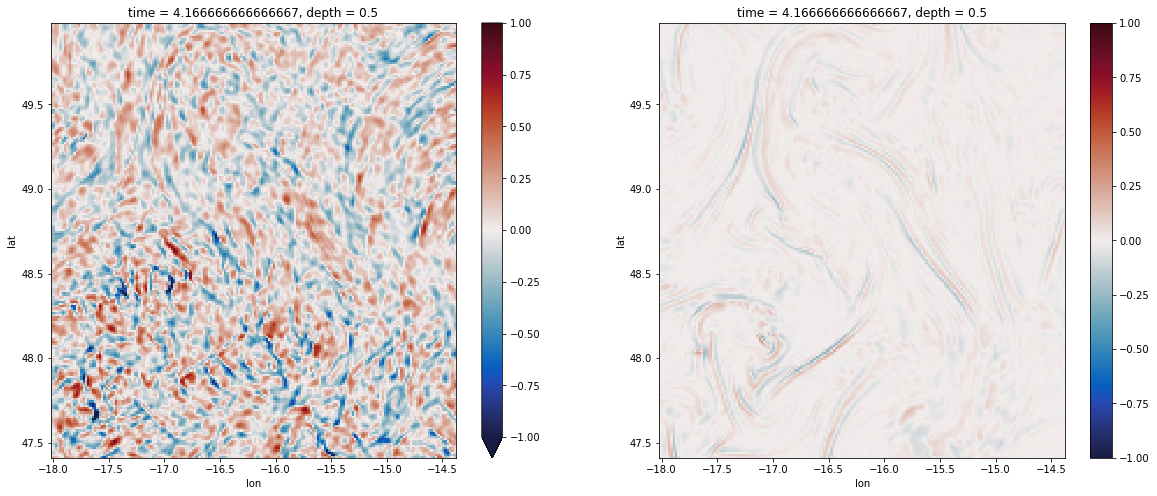

In [14]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)
plt.subplot(122)
vel_div_f_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=0).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)

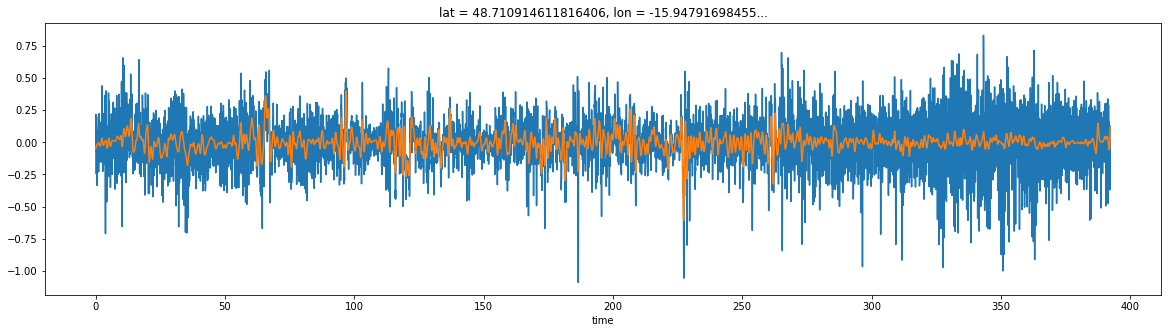

In [15]:
fig = plt.figure(figsize=(20,5))

vel_div_f.isel(lat=100, lon=100,depth=1).plot()
vel_div_f_filter.isel(lat=100, lon=100,depth=1).plot()

## 3.5 lateral gradient

In [26]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')
db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)
print(lateral_buoyancy_gradient)

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<sqrt, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 1, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-10-09T06:00:00
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


In [27]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')
db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij_filter*db_dx_ij_filter + db_dy_ij_filter*db_dy_ij_filter)
print(lateral_buoyancy_gradient_filter)

<xarray.DataArray (time: 8761, depth: 40, lat: 201, lon: 177)>
dask.array<sqrt, shape=(8761, 40, 201, 177), dtype=float32, chunksize=(8761, 1, 1, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ... 2012-09-12
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 410.4 441.3 473.3 506.5
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36


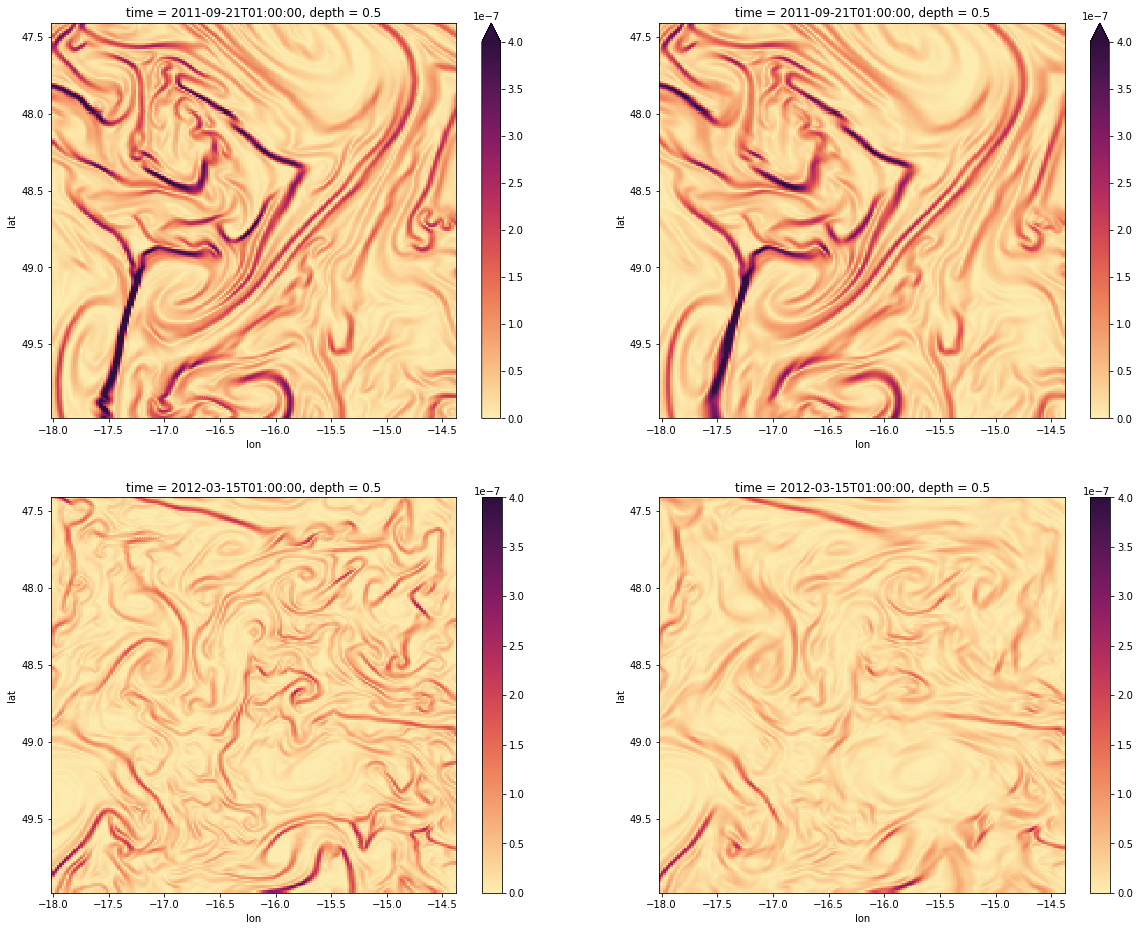

In [29]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)
plt.subplot(222)
lateral_buoyancy_gradient_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

plt.subplot(223)
lateral_buoyancy_gradient.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)
plt.subplot(224)
lateral_buoyancy_gradient_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=0).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=0, vmax=4e-7,cmap=cm.matter, yincrease=False)

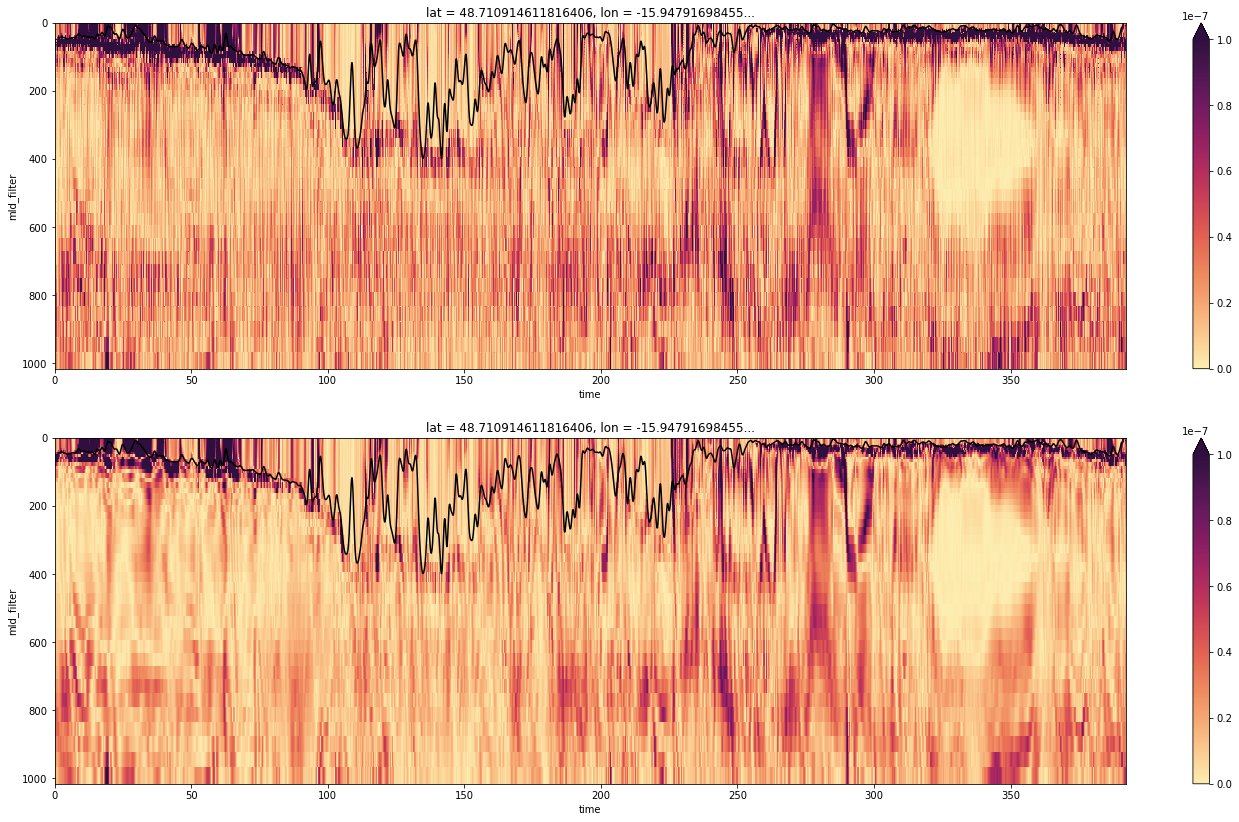

In [34]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
lateral_buoyancy_gradient.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
lateral_buoyancy_gradient_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=0,vmax=1e-7,cmap=cm.matter, yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.6 PV

In [35]:
zeta = (gridx.diff(ds.dyC*ds['V'],'X') - gridx.diff(ds.dxC * ds['U'],'Y'))/ds.rAz
zeta_i =  gridx.interp(zeta,'X')
zeta_ij =  gridx.interp(zeta_i,'Y')

db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

PV = (f_ij + zeta_ij)*db_dz - (db_dx_ij**2 + db_dy_ij**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV = PV.chunk(chunks)
PV

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [37]:
zeta_filter = (gridx.diff(ds_filter.dyC*ds_filter['V_low_filter'],'X') - gridx.diff(ds_filter.dxC * ds_filter['U_low_filter'],'Y'))/ds_filter.rAz
zeta_i_filter =  gridx.interp(zeta_filter,'X')
zeta_ij_filter =  gridx.interp(zeta_i_filter,'Y')

db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

PV_filter = (f_ij + zeta_ij_filter)*db_dz_filter - (db_dx_ij_filter**2 + db_dy_ij_filter**2)/f_ij
chunks = {'time': 9415, 'lat': 201, 'lon': 177, 'depth':1}
PV_filter = PV_filter.chunk(chunks)
PV_filter

<xarray.DataArray (lat: 201, lon: 177, time: 9415, depth: 52)>
dask.array<rechunk-merge, shape=(201, 177, 9415, 52), dtype=float32, chunksize=(201, 177, 9415, 1), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

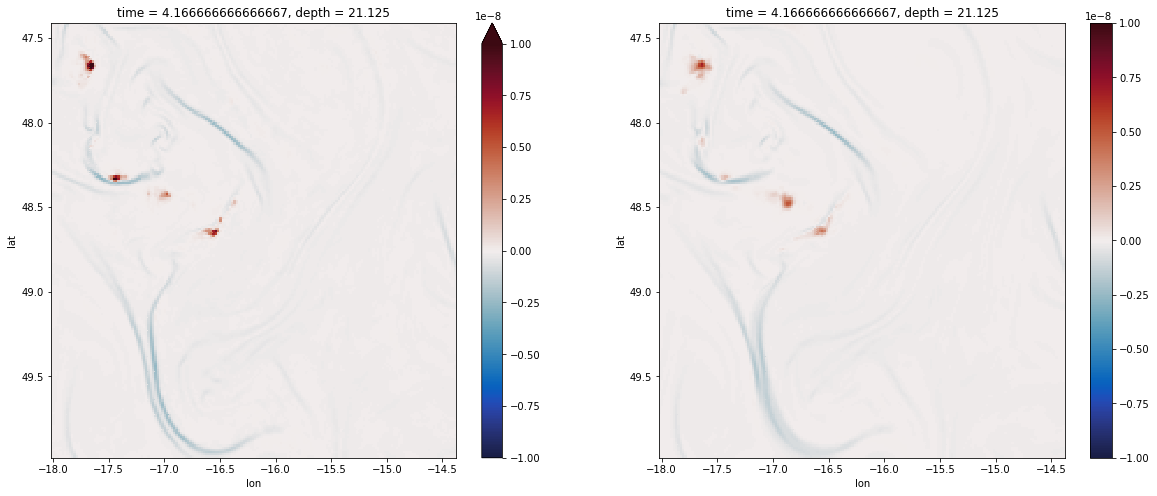

In [38]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
PV.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)
plt.subplot(122)
PV_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1e-8, vmax=1e-8,cmap=cm.balance, yincrease=False)

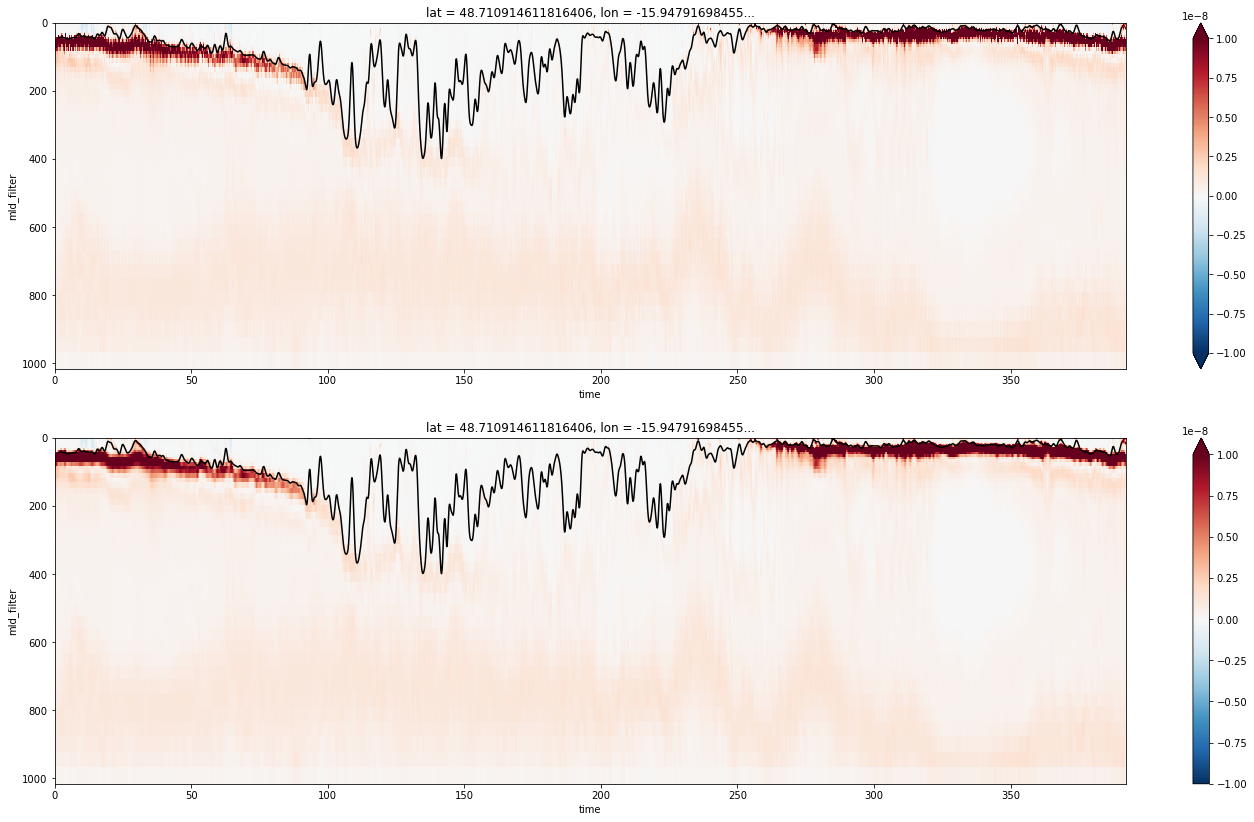

In [39]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
PV.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
PV_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1e-8,vmax=1e-8,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.7 Richardson number

In [44]:
db_dz_left = -1*gridx.diff(ds.Buoy, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz = gridx.interp(db_dz_left,'Z', boundary='fill')
db_dz = db_dz.astype(np.float32)

dU_dz_left = -1*gridx.diff(ds.U, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1 = gridx.interp(dU_dz_left,'Z', boundary='fill')
dU_dz = gridx.interp(dU_dz_1,'X')
dU_dz = dU_dz.astype(np.float32)

dV_dz_left = -1*gridx.diff(ds.V, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1 = gridx.interp(dV_dz_left,'Z', boundary='fill')
dV_dz = gridx.interp(dV_dz_1,'Y')
dV_dz = dV_dz.astype(np.float32)

Ri = db_dz/(dU_dz**2 + dV_dz**2)
Ri

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [45]:
db_dz_left_filter = -1*gridx.diff(ds_filter.B_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc  #### -1* is necessary to make the sign correct ####
db_dz_filter = gridx.interp(db_dz_left_filter,'Z', boundary='fill')
db_dz_filter = db_dz_filter.astype(np.float32)

dU_dz_left_filter = -1*gridx.diff(ds_filter.U_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dU_dz_1_filter = gridx.interp(dU_dz_left_filter,'Z', boundary='fill')
dU_dz_filter = gridx.interp(dU_dz_1_filter,'X')
dU_dz_filter = dU_dz_filter.astype(np.float32)

dV_dz_left_filter = -1*gridx.diff(ds_filter.V_low_filter, 'Z', boundary='fill', fill_value=np.nan) / ds.dzc
dV_dz_1_filter = gridx.interp(dV_dz_left_filter,'Z', boundary='fill')
dV_dz_filter = gridx.interp(dV_dz_1_filter,'Y')
dV_dz_filter = dV_dz_filter.astype(np.float32)

Ri_filter = db_dz_filter/(dU_dz_filter**2 + dV_dz_filter**2)
Ri_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 200, 176), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

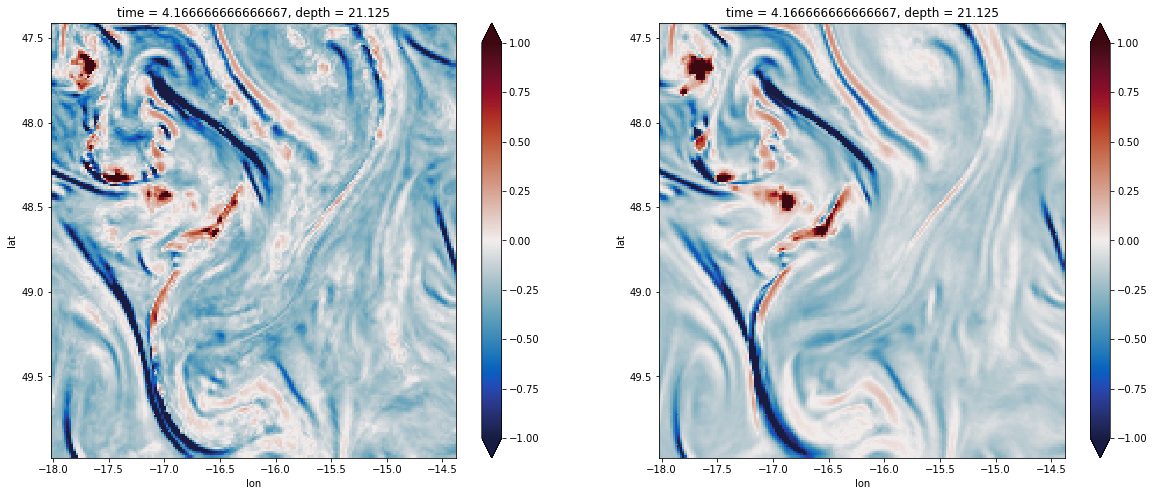

In [49]:
fig = plt.figure(figsize=(20,8))

plt.subplot(121)
Ri.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
plt.subplot(122)
Ri_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)

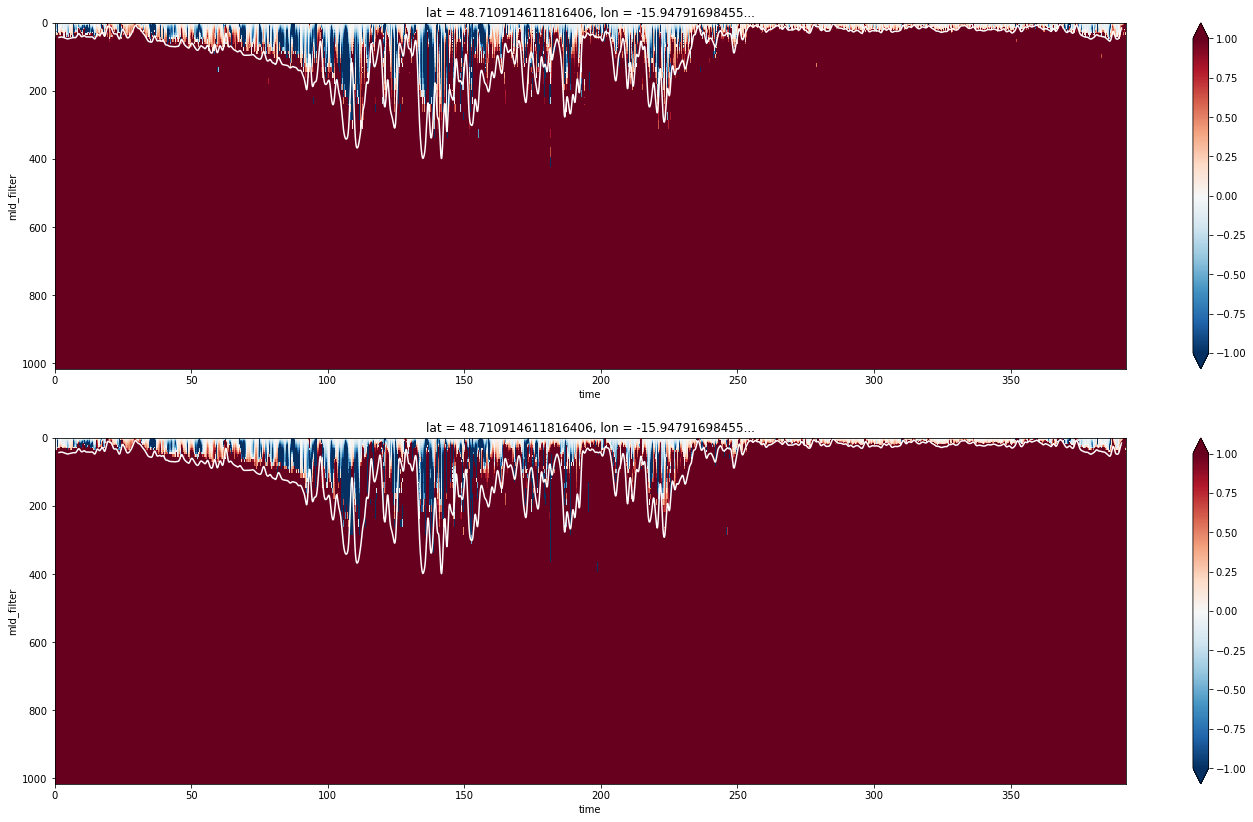

In [50]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Ri.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

plt.subplot(212)
Ri_filter.isel(lat=100,lon=100).plot(x='time', y='depth',vmin=-1,vmax=1,cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='white', yincrease=False)

## 3.8 Frontogenesis function

In [30]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')
du_dx_ij

dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')
du_dy_ij

dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')
dv_dx_ij

dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij

Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)

In [31]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')

db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

du_dx_ij_filter = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds.dxG, 'Y')


dU_dy_1_filter = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2_filter = gridx.interp(dU_dy_1_filter, 'X')
du_dy_ij_filter = gridx.interp(dU_dy_2_filter, 'Y')

dV_dx_1_filter = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2_filter = gridx.interp(dV_dx_1_filter, 'X')
dv_dx_ij_filter = gridx.interp(dV_dx_2_filter, 'Y')

dv_dy_ij_filter = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij_filter

Fs_filter = -(du_dx_ij_filter*db_dx_ij_filter*db_dx_ij_filter + dv_dx_ij_filter*db_dx_ij_filter*db_dy_ij_filter + du_dy_ij_filter*db_dx_ij_filter*db_dy_ij_filter + dv_dy_ij_filter*db_dy_ij_filter*db_dy_ij_filter)
Fs_filter

<xarray.DataArray (time: 8761, depth: 40, lat: 201, lon: 177)>
dask.array<neg, shape=(8761, 40, 201, 177), dtype=float32, chunksize=(8761, 1, 1, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00 ... 2012-09-12
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 410.4 441.3 473.3 506.5
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

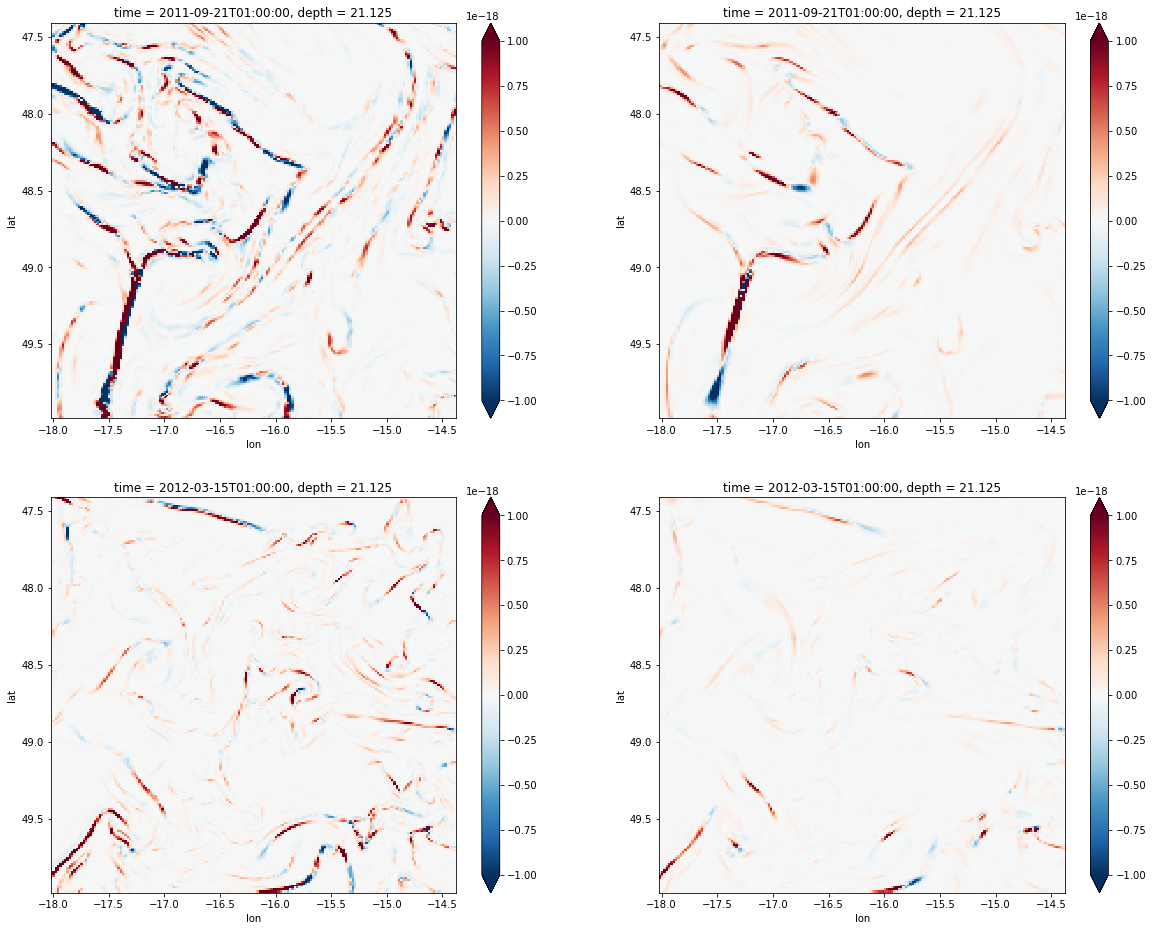

In [32]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
Fs.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)
plt.subplot(222)
Fs_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2011-09-21T01:00:00').plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)

plt.subplot(223)
Fs.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)
plt.subplot(224)
Fs_filter.isel(lat=slice(1,-1),lon=slice(1,-1),depth=10).sel(time='2012-03-15T01:00:00').plot(x='lon', y='lat', vmin=-1e-18, vmax=1e-18,cmap='RdBu_r', yincrease=False)

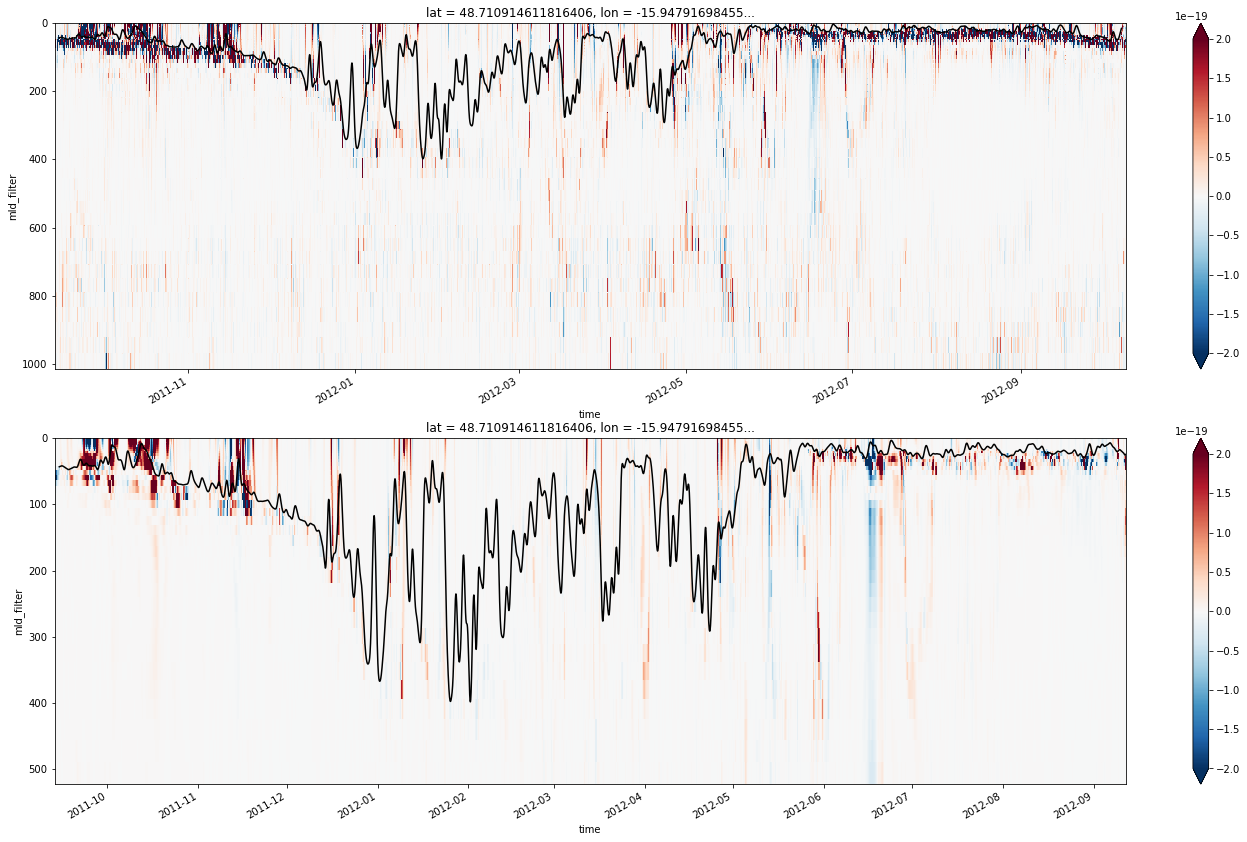

In [33]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Fs.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-2e-19, vmax=2e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
Fs_filter.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-2e-19, vmax=2e-19, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

## 3.9 Frontogenesis tendency

In [11]:
db_dx = gridx.diff(ds['Buoy'],'X')/ds.dxC     # db/dx
db_dx_ij = gridx.interp(db_dx,'X')

db_dy = gridx.diff(ds['Buoy'],'Y')/ds.dyC     # db/dy
db_dy_ij = gridx.interp(db_dy,'Y')

du_dx_ij = gridx.diff(ds['U'], 'X')/gridx.interp(ds.dxG, 'Y')

dU_dy_1 = gridx.diff(ds['U'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2 = gridx.interp(dU_dy_1, 'X')
du_dy_ij = gridx.interp(dU_dy_2, 'Y')

dV_dx_1 = gridx.diff(ds['V'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2 = gridx.interp(dV_dx_1, 'X')
dv_dx_ij = gridx.interp(dV_dx_2, 'Y')

dv_dy_ij = gridx.diff(ds['V'], 'Y')/gridx.interp(ds.dyG, 'X')

Fs = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)
lateral_buoyancy_gradient = np.sqrt(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)

Tb = -(du_dx_ij*db_dx_ij*db_dx_ij + dv_dx_ij*db_dx_ij*db_dy_ij + du_dy_ij*db_dx_ij*db_dy_ij + dv_dy_ij*db_dy_ij*db_dy_ij)/(db_dx_ij*db_dx_ij + db_dy_ij*db_dy_ij)
Tb

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [12]:
db_dx_filter = gridx.diff(ds_filter['B_low_filter'],'X')/ds.dxC     # db/dx
db_dx_ij_filter = gridx.interp(db_dx_filter,'X')

db_dy_filter = gridx.diff(ds_filter['B_low_filter'],'Y')/ds.dyC     # db/dy
db_dy_ij_filter = gridx.interp(db_dy_filter,'Y')

du_dx_ij_filter = gridx.diff(ds_filter['U_low_filter'], 'X')/gridx.interp(ds.dxG, 'Y')


dU_dy_1_filter = gridx.diff(ds_filter['U_low_filter'], 'Y')/gridx.interp(ds.dyC, 'X')
dU_dy_2_filter = gridx.interp(dU_dy_1_filter, 'X')
du_dy_ij_filter = gridx.interp(dU_dy_2_filter, 'Y')

dV_dx_1_filter = gridx.diff(ds_filter['V_low_filter'], 'X')/gridx.interp(ds.dxC, 'Y')
dV_dx_2_filter = gridx.interp(dV_dx_1_filter, 'X')
dv_dx_ij_filter = gridx.interp(dV_dx_2_filter, 'Y')

dv_dy_ij_filter = gridx.diff(ds_filter['V_low_filter'], 'Y')/gridx.interp(ds.dyG, 'X')
dv_dy_ij_filter

Fs_filter = -(du_dx_ij_filter*db_dx_ij_filter*db_dx_ij_filter + dv_dx_ij_filter*db_dx_ij_filter*db_dy_ij_filter + du_dy_ij_filter*db_dx_ij_filter*db_dy_ij_filter + dv_dy_ij_filter*db_dy_ij_filter*db_dy_ij_filter)
lateral_buoyancy_gradient_filter = np.sqrt(db_dx_ij_filter*db_dx_ij_filter + db_dy_ij_filter*db_dy_ij_filter)

Tb_filter = -(du_dx_ij_filter*db_dx_ij_filter*db_dx_ij_filter + dv_dx_ij_filter*db_dx_ij_filter*db_dy_ij_filter + du_dy_ij_filter*db_dx_ij_filter*db_dy_ij_filter + dv_dy_ij_filter*db_dy_ij_filter*db_dy_ij_filter)/(db_dx_ij_filter*db_dx_ij_filter + db_dy_ij_filter*db_dy_ij_filter)
Tb_filter

<xarray.DataArray (time: 9415, depth: 52, lat: 201, lon: 177)>
dask.array<truediv, shape=(9415, 52, 201, 177), dtype=float32, chunksize=(9415, 1, 199, 175), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36

In [13]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'
depth_all = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]

In [14]:
# works better with few worker but a lot of memories
VV = ['Tb']

for depth in depth_all:
    
    for vv in VV:
        
        Tb_single = Tb.isel(depth=depth)/f_ij
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        Tb_single = Tb_single.chunk(chunks)
        Tb_single = np.real(Tb_single).rename('Tb_single')     
        Tb_single = Tb_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Tb_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [15]:
# works better with few worker but a lot of memories
VV = ['Tb_filter']

for depth in depth_all:
    
    for vv in VV:
        
        Tb_filter_single = Tb_filter.isel(depth=depth)/f_ij
        chunks = {'lat': 201, 'lon': 177, 'time':9415}            
        Tb_filter_single = Tb_filter_single.chunk(chunks)
        Tb_filter_single = np.real(Tb_filter_single).rename('Tb_filter_single')     
        Tb_filter_single = Tb_filter_single.to_dataset()
        file_out = out_dir_store+'/%s_d%02d.zarr'%(vv,depth)
        Tb_filter_single.to_zarr(file_out, mode='w')                    
        print('depth=%d - allready processed'%(depth))

depth=0 - allready processed
depth=1 - allready processed
depth=2 - allready processed
depth=3 - allready processed
depth=4 - allready processed
depth=5 - allready processed
depth=6 - allready processed
depth=7 - allready processed
depth=8 - allready processed
depth=9 - allready processed
depth=10 - allready processed
depth=11 - allready processed
depth=12 - allready processed
depth=13 - allready processed
depth=14 - allready processed
depth=15 - allready processed
depth=16 - allready processed
depth=17 - allready processed
depth=18 - allready processed
depth=19 - allready processed
depth=20 - allready processed
depth=21 - allready processed
depth=22 - allready processed
depth=23 - allready processed
depth=24 - allready processed
depth=25 - allready processed
depth=26 - allready processed
depth=27 - allready processed
depth=28 - allready processed
depth=29 - allready processed
depth=30 - allready processed
depth=31 - allready processed
depth=32 - allready processed
depth=33 - allready 

In [16]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'
D = [xr.open_zarr(out_dir_store+'Tb_d%02d.zarr'%(depth)) for depth in range(52)]

Tb = xr.concat(D, dim='depth')
Tb = Tb.Tb_single
Tb

<xarray.DataArray 'Tb_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [17]:
out_dir_store = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'
D = [xr.open_zarr(out_dir_store+'Tb_filter_d%02d.zarr'%(depth)) for depth in range(52)]

Tb_filter = xr.concat(D, dim='depth')
Tb_filter = Tb_filter.Tb_filter_single
Tb_filter

<xarray.DataArray 'Tb_filter_single' (depth: 52, time: 9415, lat: 201, lon: 177)>
dask.array<concatenate, shape=(52, 9415, 201, 177), dtype=float32, chunksize=(1, 9415, 201, 177), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon      (lon) float64 -18.03 -18.01 -17.99 -17.97 ... -14.41 -14.39 -14.36
  * time     (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
  * depth    (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3

In [21]:
store_dir_zarr = '/home1/scratch/xyu/OSMOSIS_llc4320/parameter/'

vel_div_f = xr.open_zarr(store_dir_zarr+'/vel_div_f_rechunk.zarr')
vel_div_f

<xarray.Dataset>
Dimensions:    (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
    CS         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth      (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XC         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * depth      (depth) float64 0.5 1.57 2.79 4.185 ... 855.8 900.1 945.6 992.3
  * lat        (lat) float64 47.4 47.42 47.43 47.44 ... 49.95 49.96 49.98 49.99
  * lon        (lon) float64 -18.03 -18.01 -17.99 ... -14.41 -14.39 -14.36
    rA         (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 392.2 392.2 392.2
Data variables:
    vel_div_f  (lat, lon, time, depth) float32 dask.array<chunksize=(201, 177, 

In [22]:
vel_div_f_filter = xr.open_zarr(store_dir_zarr+'/vel_div_f_filter_rechunk.zarr')
vel_div_f_filter

<xarray.Dataset>
Dimensions:           (depth: 52, lat: 201, lon: 177, time: 9415)
Coordinates:
    CS                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    Depth             (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    SN                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    XC                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
    YC                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * depth             (depth) float64 0.5 1.57 2.79 4.185 ... 900.1 945.6 992.3
  * lat               (lat) float64 47.4 47.42 47.43 47.44 ... 49.96 49.98 49.99
  * lon               (lon) float64 -18.03 -18.01 -17.99 ... -14.39 -14.36
    rA                (lat, lon) float32 dask.array<chunksize=(201, 177), meta=np.ndarray>
  * time              (time) float64 0.0 0.04167 0.08333 ... 392.2 392.2 392.2
Data variables:
    vel_div_f_filter  (lat,

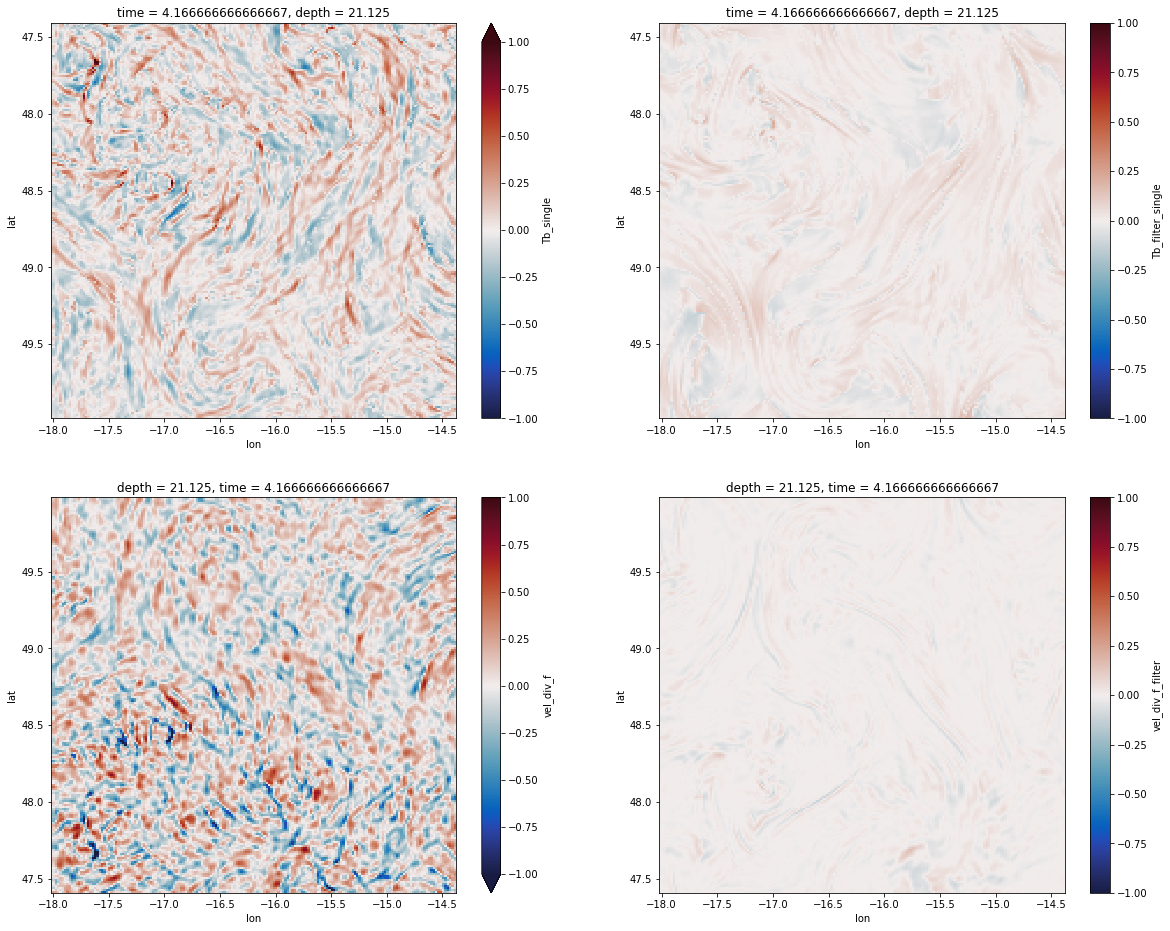

In [23]:
fig = plt.figure(figsize=(20,16))

plt.subplot(221)
Tb.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
plt.subplot(222)
Tb_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1, vmax=1,cmap=cm.balance, yincrease=False)
plt.subplot(223)
vel_div_f.vel_div_f.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)
plt.subplot(224)
vel_div_f_filter.vel_div_f_filter.isel(lat=slice(1,-1),lon=slice(1,-1),time=100,depth=10).plot(x='lon', y='lat', vmin=-1., vmax=1., cmap=cm.balance)

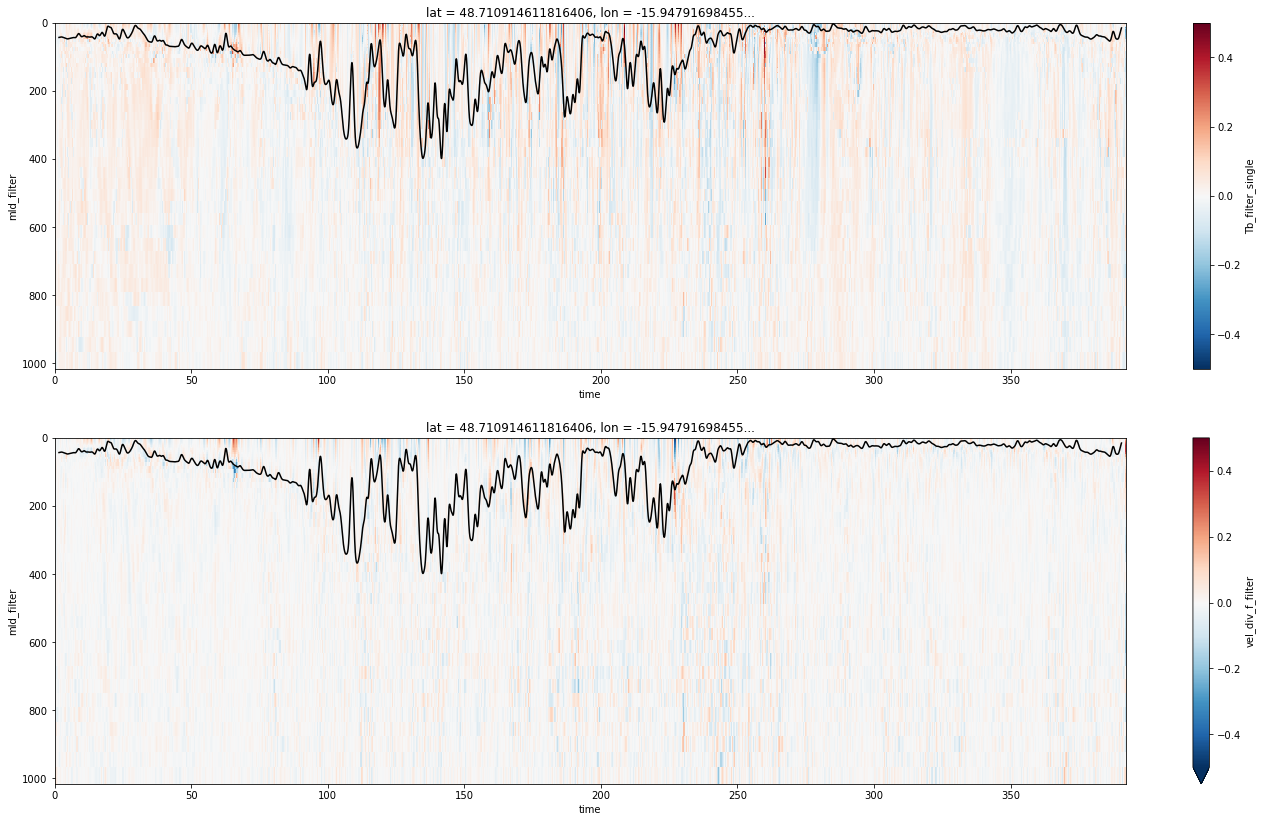

In [24]:
fig = plt.figure(figsize=(24,14))

plt.subplot(211)
Tb_filter.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-.5, vmax=.5, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

plt.subplot(212)
vel_div_f_filter.vel_div_f_filter.isel(lat=100,lon=100).plot(x='time', y='depth', vmin=-.5, vmax=.5, cmap='RdBu_r', yincrease=False)
ds.mld_filter.isel(lat=100,lon=100).plot(x='time',color='black', yincrease=False)

In [35]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1276, in _close
    await gen.with_timeout(timedelta(seconds=2), list(coroutines))
concurrent.futures._base.CancelledError
distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/utils.py", line 666, in log_errors
    yield
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1005, in _reconnect
    await self._close()
  File "/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.7/site-packages/distributed/client.py", line 1